In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.cluster import *
import matplotlib.pyplot as plt
data_set = pd.read_csv('/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Pottipadu_PPD01.csv')

def scale_data(data_set_to_be_scaled, scale_wind_speed_factor=1, scale_active_power_factor=1):
    data_set = data_set_to_be_scaled[data_set_to_be_scaled['ActivePower'] > 0].copy()

    max_wind_speed = data_set['WindSpeed'].max()
    min_wind_speed = data_set['WindSpeed'].min()
    max_active_power = data_set['ActivePower'].max()
    min_active_power = data_set['ActivePower'].min()
    normalization_factor_wind_speed = max_wind_speed - min_wind_speed
    normalization_factor_active_power = max_active_power - min_active_power

    data_set['scaled_WindSpeed'] = ((data_set['WindSpeed'] - min_wind_speed) * scale_wind_speed_factor) \
                                                / normalization_factor_wind_speed
    data_set['scaled_ActivePower'] = ((data_set['ActivePower'] - min_active_power) * scale_active_power_factor) \
                                                / normalization_factor_active_power

    return data_set.copy()

def custom_curve(x, a, b):
    return 1/(1 + np.exp(-a * x + b))

def curve_params(data_set):

    curve_set['cluster_number'] = DBSCAN(eps=0.015, min_samples=15).fit_predict(data_set[['scaled_WindSpeed', 'scaled_ActivePower']])

    curve_limits = curve_set[((curve_set['cluster_number'] == 0) & (curve_set['scaled_ActivePower'] < 0.87) & (curve_set['scaled_ActivePower'] > 0.05)) | (curve_set['scaled_ActivePower'] > 0.87)]

#     def custom_curve(x, a, b):
#         #(a, 0) & (b, 1)
#         if x > a and x < b:
#             return (x - a) / (b - a)
#         elif x < a:
#             return 0
#         elif x > b:
#             return 1

#     def custom_curve(x, a, b):
#         return (DiracDelta(x - a > 0) * DiracDelta(x - b < 0)) * (x - a) / (b - a) \
#                 + DiracDelta(x - a <= 0) * 0 \
#                 + DiracDelta(x - b >= 1) * 1

    
    params_optimal, params_covariance = curve_fit(custom_curve, curve_limits['scaled_WindSpeed'], \
                                                      curve_limits['scaled_ActivePower'])

    return (params_optimal, params_covariance)
    
    
def rounding_method(multiply_factor, round_off_by_factor):
    return lambda number: int(number * multiply_factor) + round_off_by_factor - int(number * multiply_factor) % round_off_by_factor



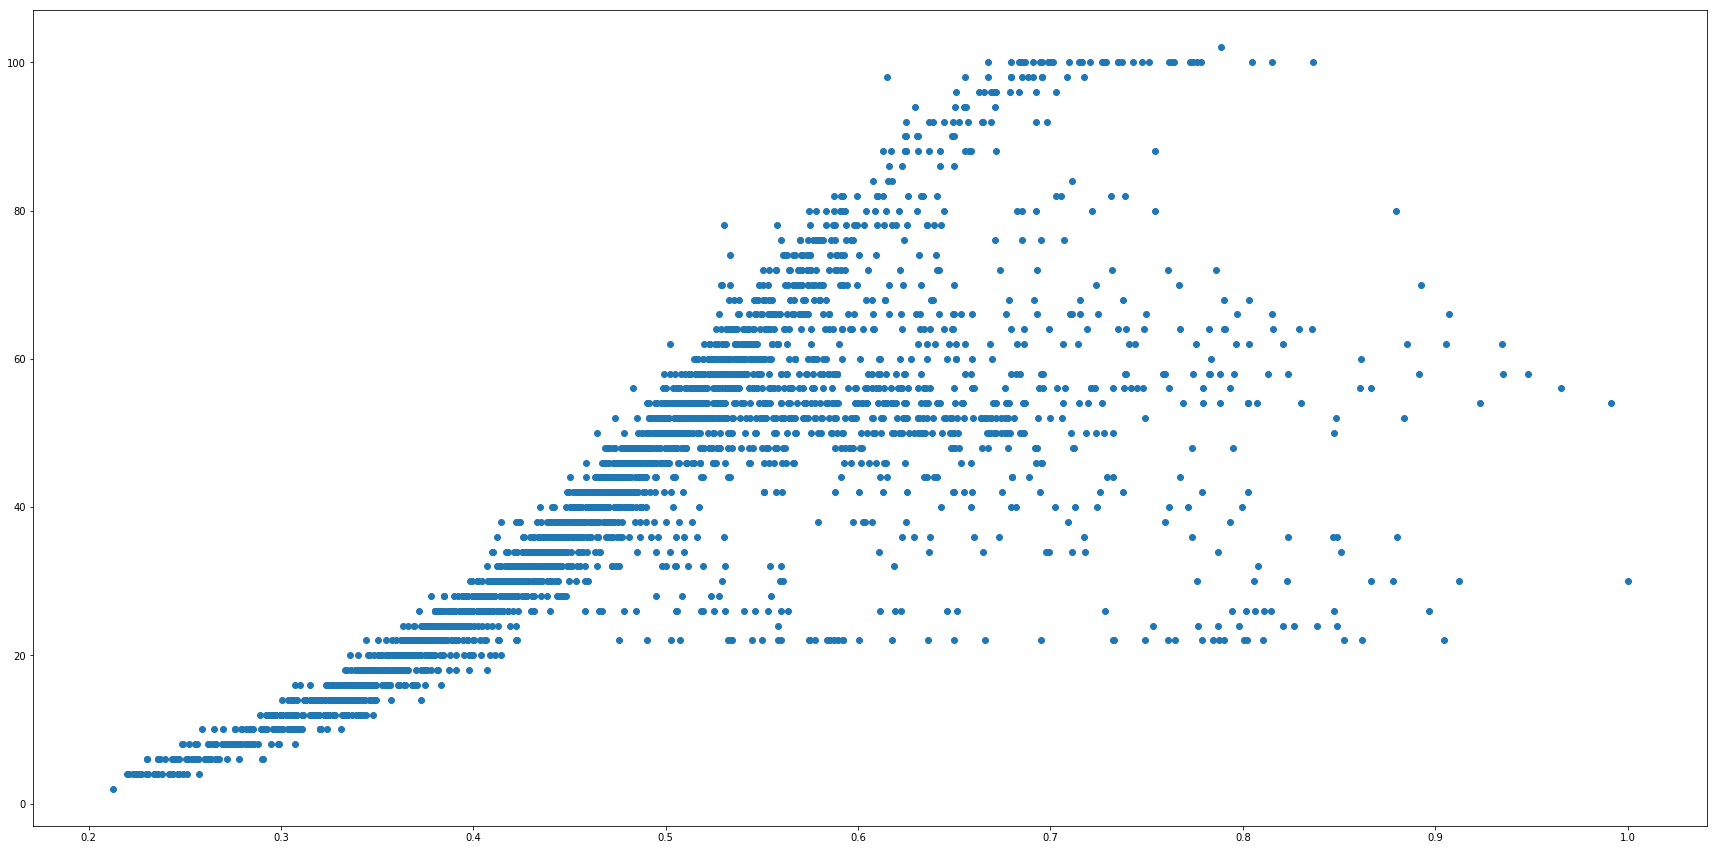

In [2]:
data_set = scale_data(data_set)
data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(100, 2))
data_set = data_set[data_set['TurbineState'] == 11]
plt.figure(figsize=(30, 15))
plt.scatter(data_set['scaled_WindSpeed'], data_set['discrete_ActivePower'])
plt.show()

In [3]:
from sklearn.cluster import KMeans

data_set = pd.read_csv('/home/mytrah-pc/Mytrah_Adithya/data_turbine/ScatterData_Pottipadu_PPD01.csv')
data_set = scale_data(data_set)
data_set['discrete_ActivePower'] = data_set['scaled_ActivePower'].apply(rounding_method(100, 2))
data_set = data_set[data_set['TurbineState'] == 11]

def cluster_each(data_set):
    kmeans_object = KMeans(n_clusters=8)
    cluster_data_set = data_set.copy()
    cluster_data_set['horizontal_cluster_number'] = -2
    cluster_centers = []
    for group in cluster_data_set.groupby('discrete_ActivePower'):
        if group[1].shape[0] < 8:
            continue
        cluster_data_set.loc[group[1].index.values, 'horizontal_cluster_number'] = kmeans_object.fit_predict(group[1][['scaled_WindSpeed', 'discrete_ActivePower']])
        cluster_centers.append(kmeans_object.cluster_centers_)
    return (cluster_data_set, cluster_centers)

dbscan_object = DBSCAN(eps=0.03, min_samples=1)

cluster_each(data_set)[1]

[array([[ 0.25025022,  4.        ],
        [ 0.23029124,  4.        ],
        [ 0.24299526,  4.        ],
        [ 0.2259097 ,  4.        ],
        [ 0.23546042,  4.        ],
        [ 0.22127712,  4.        ],
        [ 0.25737184,  4.        ],
        [ 0.24669586,  4.        ]]), array([[ 0.25427847,  6.        ],
        [ 0.27512629,  6.        ],
        [ 0.23738049,  6.        ],
        [ 0.29057303,  6.        ],
        [ 0.26607846,  6.        ],
        [ 0.24504827,  6.        ],
        [ 0.26127065,  6.        ],
        [ 0.23051134,  6.        ]]), array([[ 0.27681634,  8.        ],
        [ 0.25595916,  8.        ],
        [ 0.29745843,  8.        ],
        [ 0.28462927,  8.        ],
        [ 0.26426913,  8.        ],
        [ 0.2499824 ,  8.        ],
        [ 0.27150252,  8.        ],
        [ 0.30715952,  8.        ]]), array([[  0.26473909,  10.        ],
        [  0.3071824 ,  10.        ],
        [  0.28395339,  10.        ],
        [  0.321021

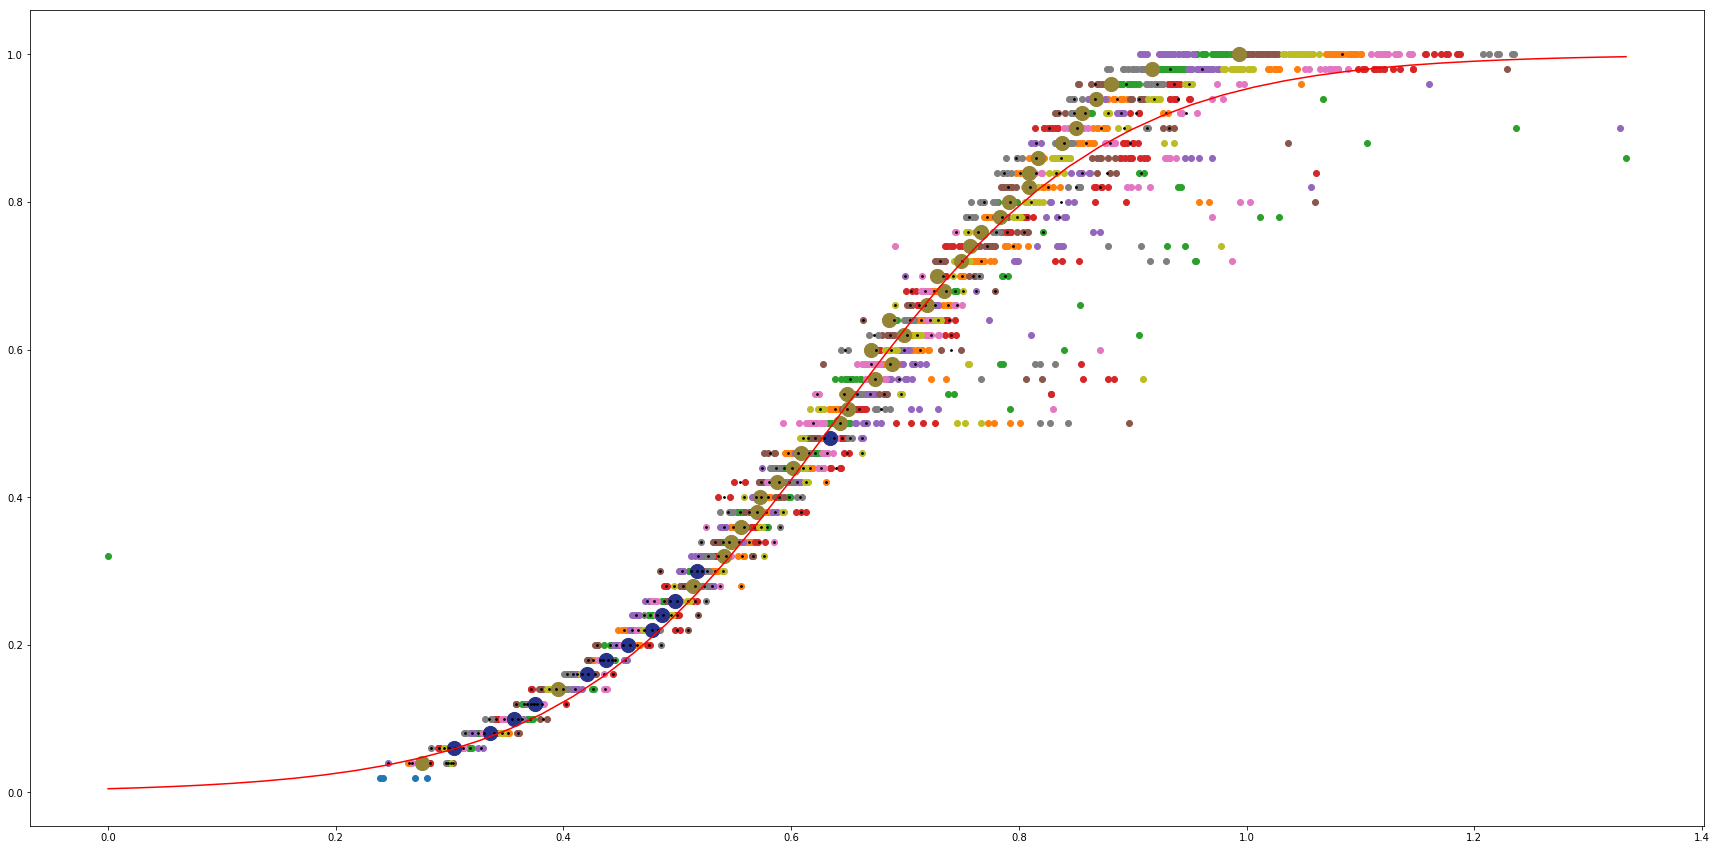

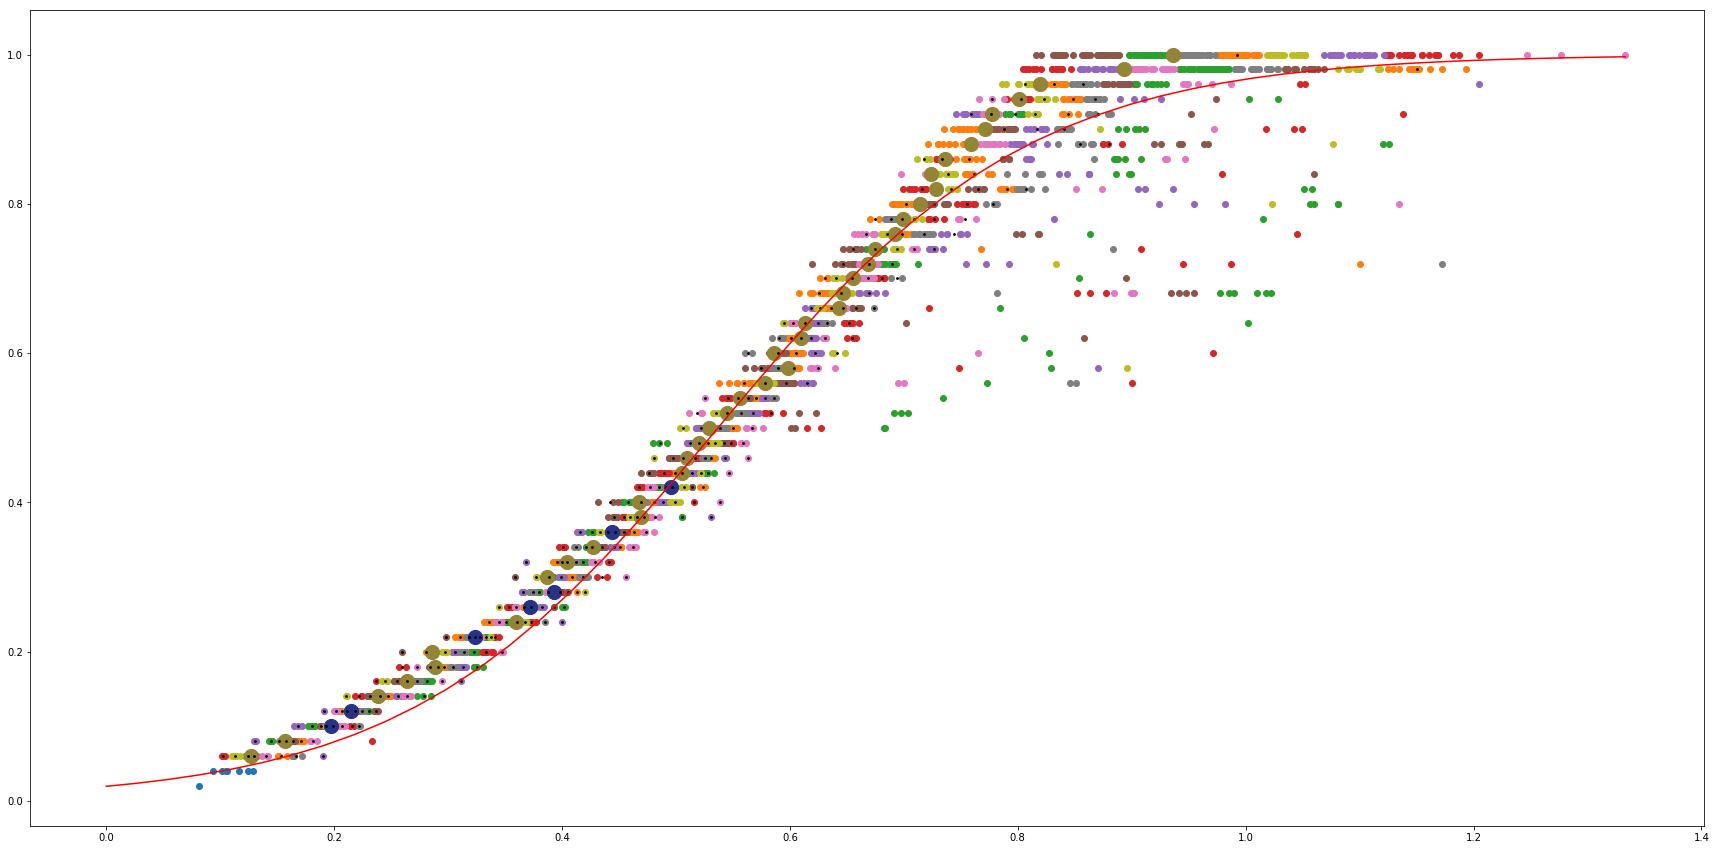

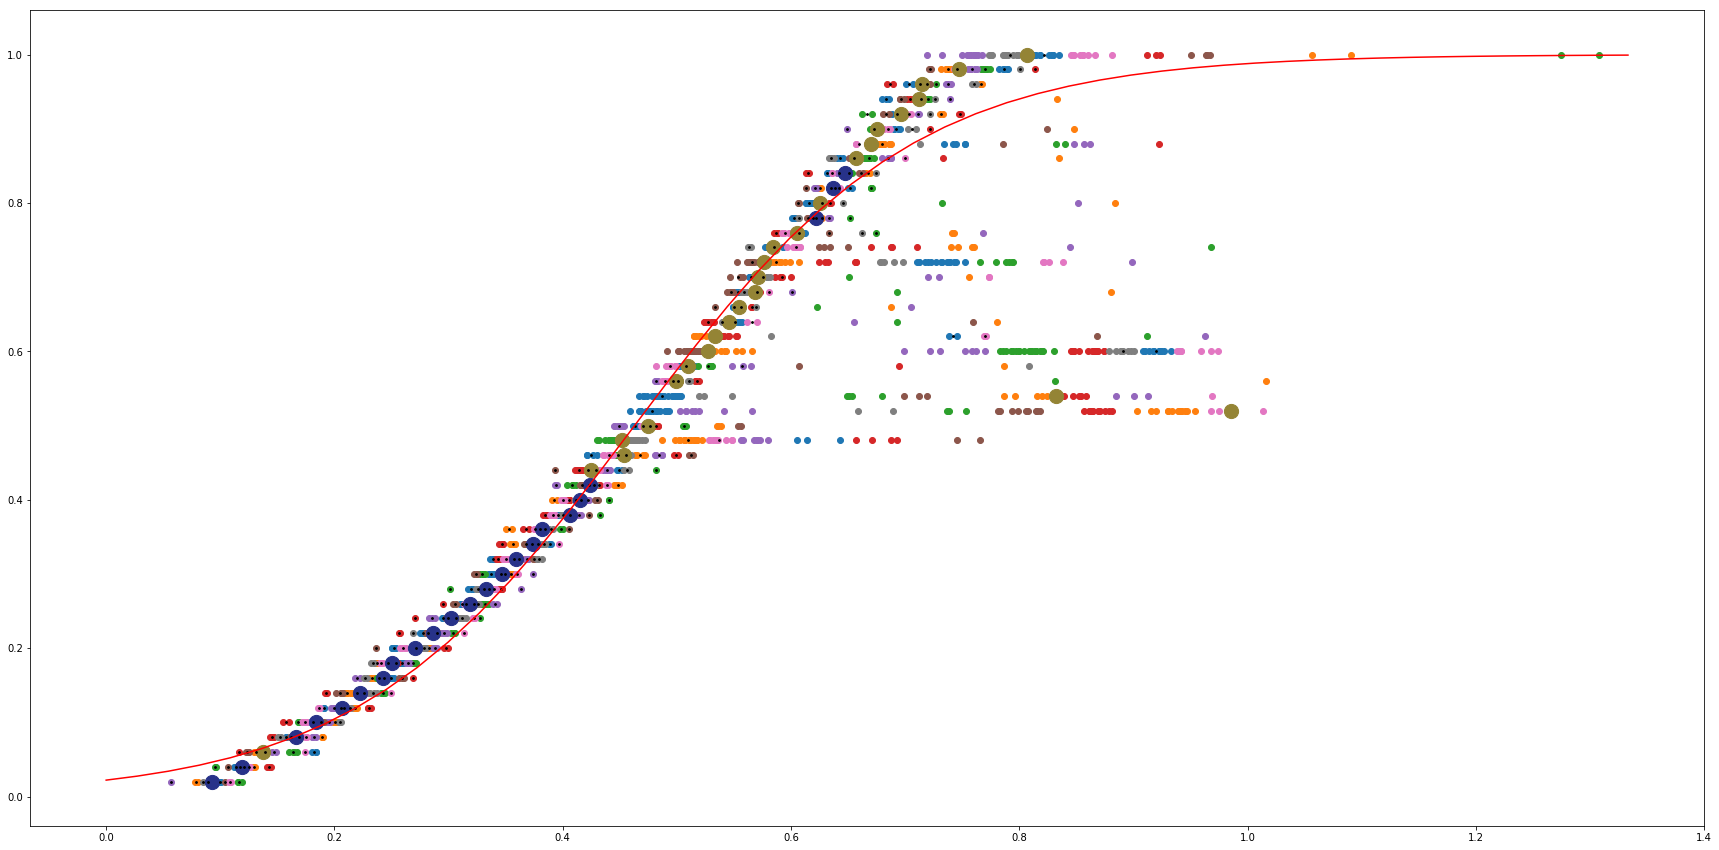

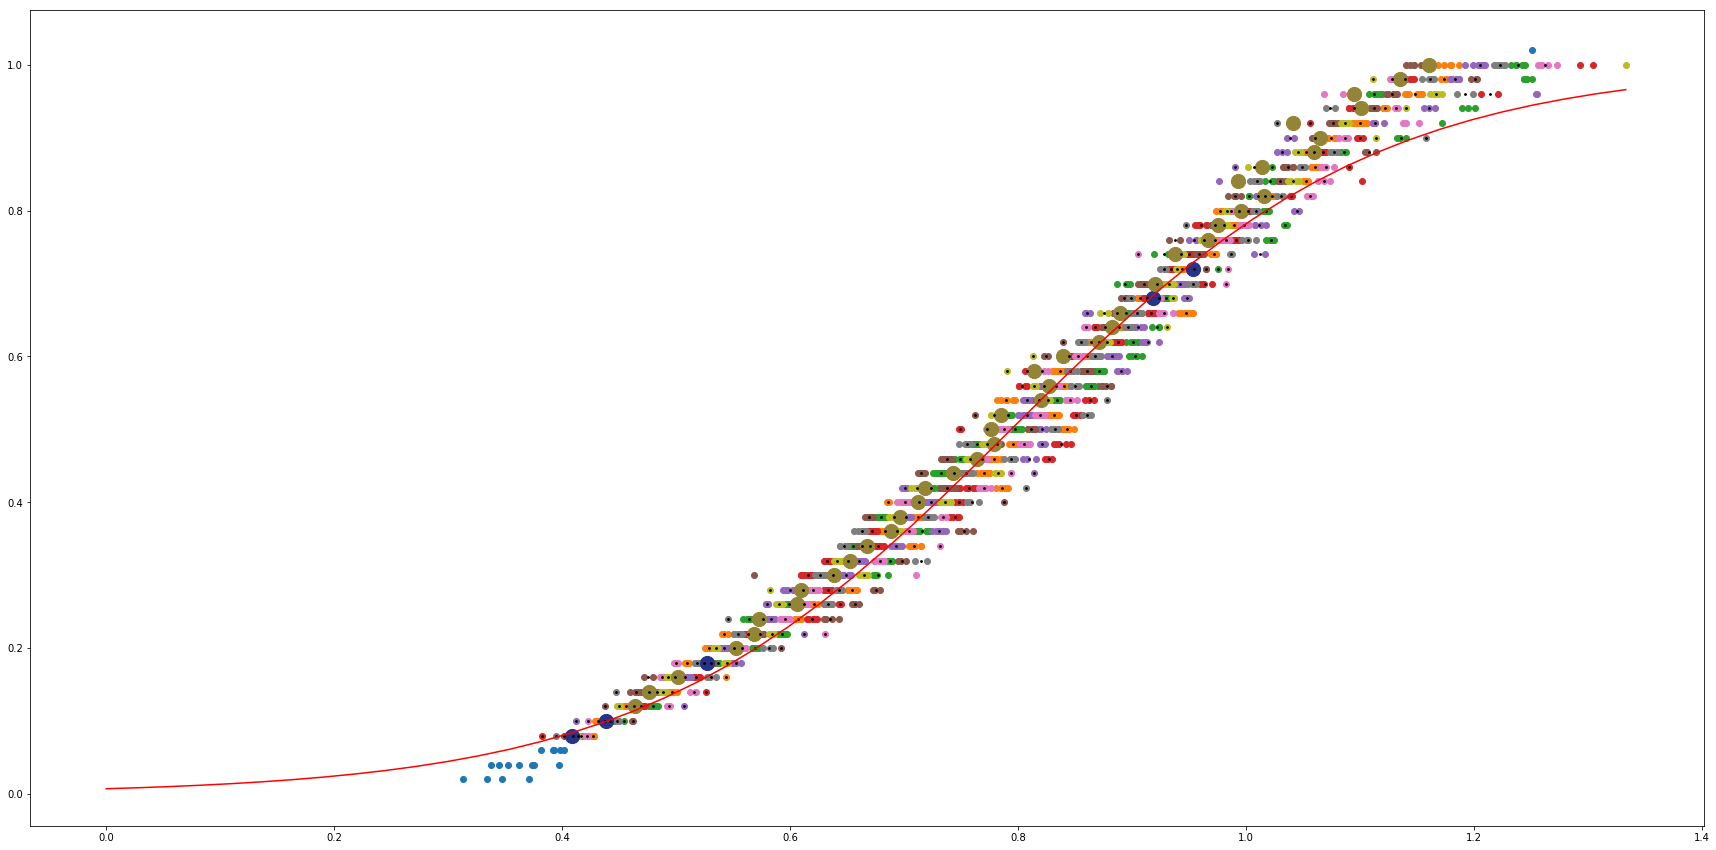

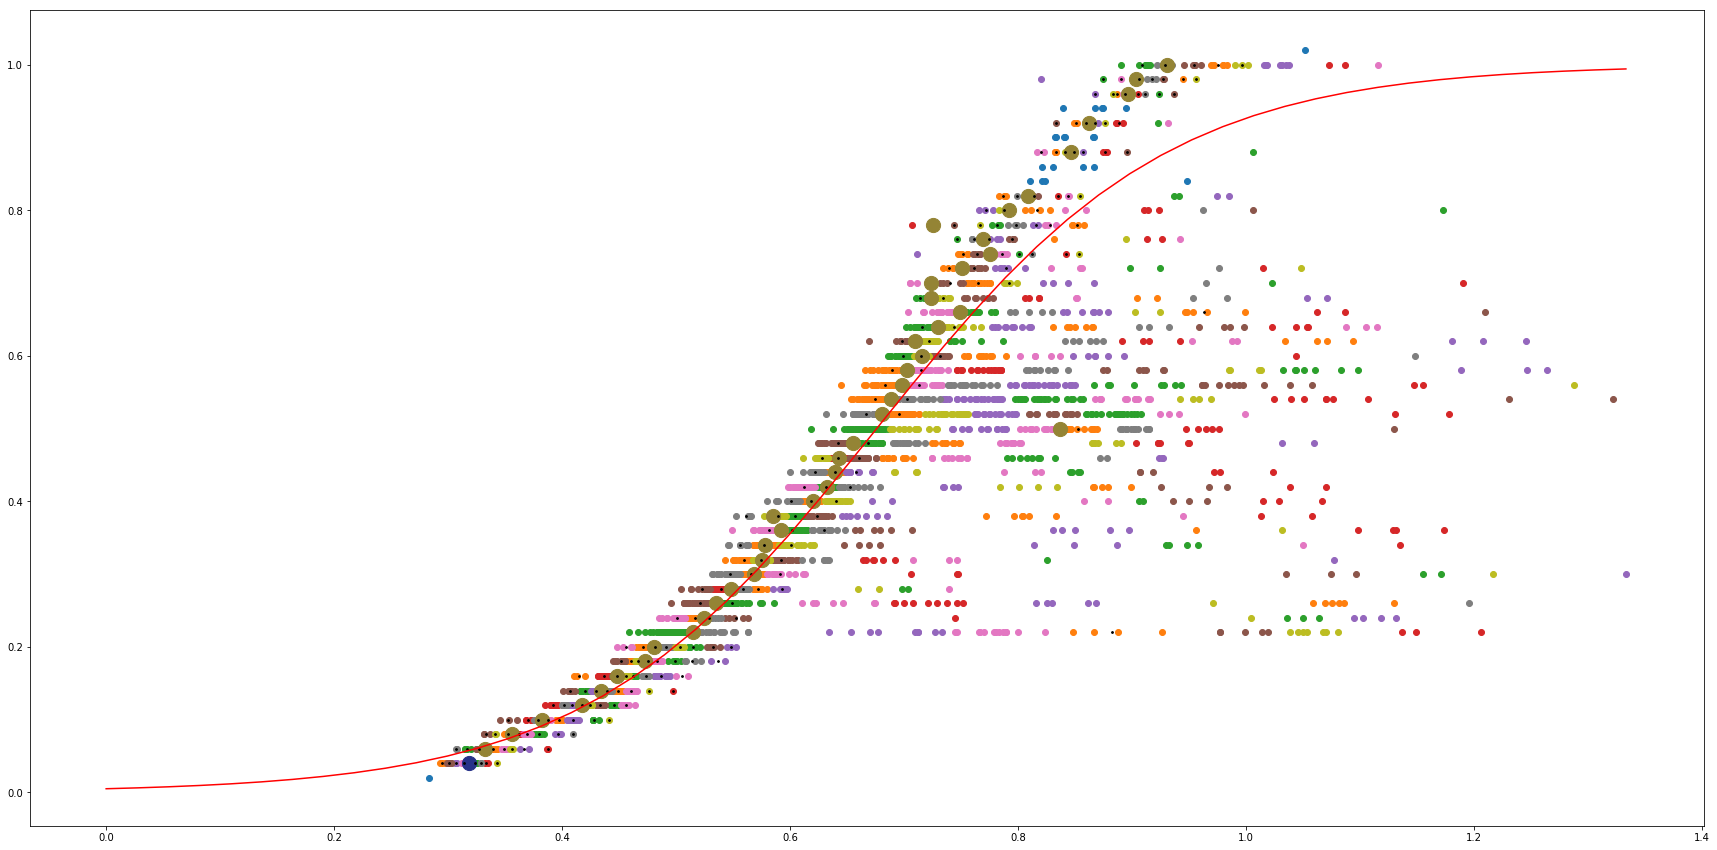

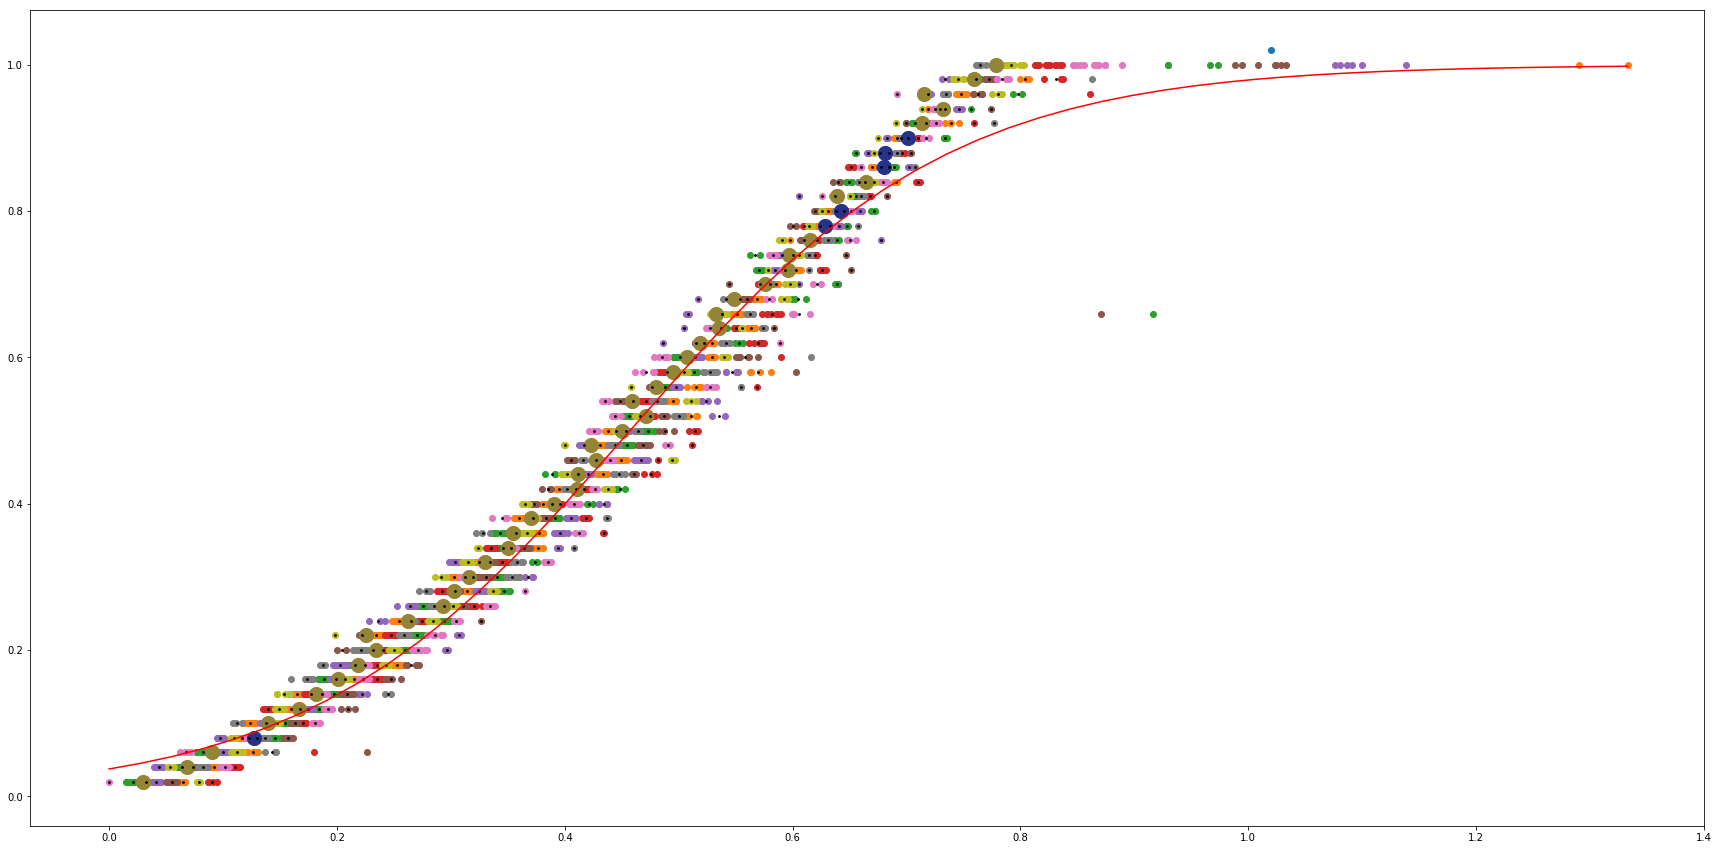

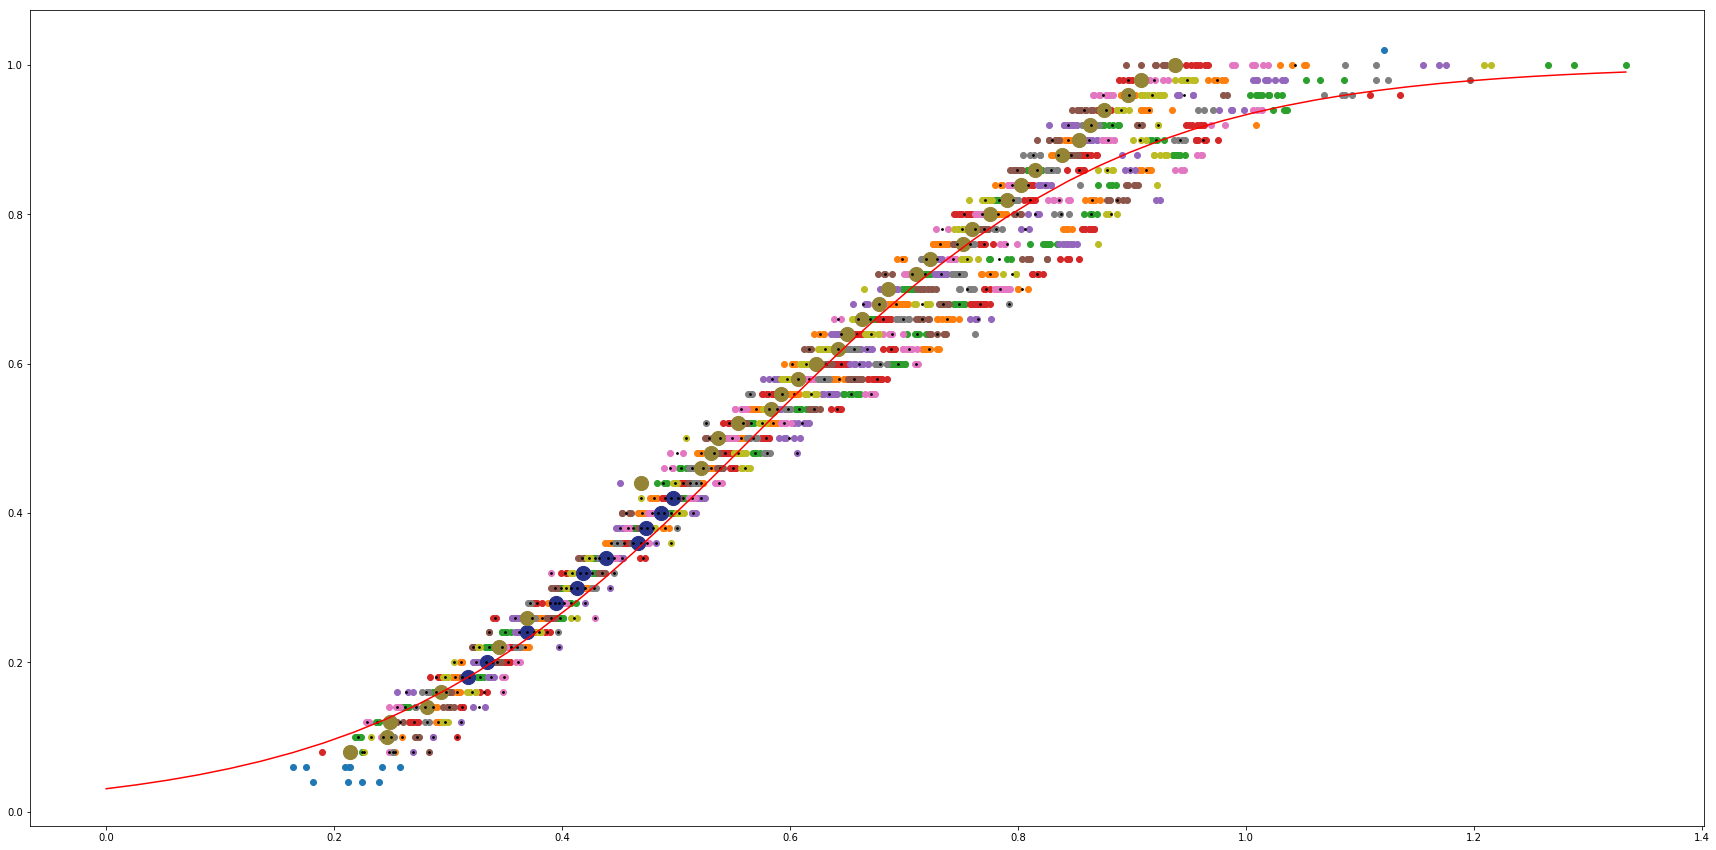

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
from sklearn.cluster import DBSCAN
from scipy.optimize import curve_fit
from os import listdir
from os.path import isfile, join

data_path = '/home/mytrah-pc/Mytrah_Adithya/data_turbine/'
for f in listdir(data_path):
    data_set = pd.read_csv(data_path + f)
    if 'TurbineState' not in data_set:
        continue
    curve_set = scale_data(data_set, 4.0/3, 1)
    curve_set = curve_set[curve_set['TurbineState'] == 11]
    if curve_set.shape[0] < 10:
        continue
    curve_set['discrete_ActivePower'] = curve_set['scaled_ActivePower'].apply(rounding_method(100, 2))
    cluster_hor = cluster_each(curve_set)
    curve_set = cluster_hor[0]
    params_optimal, params_covariance = curve_params(curve_set)
    plt.figure(figsize=(30, 15))
    for group in curve_set.groupby('horizontal_cluster_number'):
        if(group[0] == -1):
            continue
        plt.scatter(group[1]['scaled_WindSpeed'], \
                    group[1]['discrete_ActivePower'] / 100)

    for x in cluster_hor[1]:
        np.mean(x, axis=0)
        np.std(x, axis=0)
        if np.std(x, axis=0)[0] < 0.019:
            plt.scatter(np.mean(x, axis=0)[0], np.mean(x, axis=0)[1]/ 100, s=np.pi*8*8, c='#273289')
        else:
            test1 = np.sort(x, axis=0)
            m = 0
            n = 2
            prev_std = 0
            while n <= 8:
                if np.std(test1[m:n], axis=0)[0] < 0.019:
                    prev_std = np.std(test1[m:n], axis=0)[0]
                    n = n + 1
                elif prev_std == 0:
                    m = m + 1
                    n = m + 2
                else:
                    break
            
            plt.scatter(np.mean(test1[m:n-1], axis=0)[0], np.mean(test1[m:n], axis=0)[1]/ 100, s=np.pi*8*8, c='#948435')
            
            
        df_temp = pd.DataFrame(x)
        df_temp['cluster'] = dbscan_object.fit_predict(x)
        df_temp = df_temp[df_temp['cluster'] != -1]
        height = -2
        cno = -2
        for y in df_temp.groupby('cluster'):
            if y[1].shape[0] > height:
                height = y[1].shape[0]
                cno = y[0]
            #plt.scatter(y[1][0], y[1][1] / 100,  s=np.pi*6*6, c='#984773')
        plt.scatter(df_temp[df_temp['cluster'] == cno][0], df_temp[df_temp['cluster'] == cno][1] / 100,  s=np.pi*1*1, c='#000000')
    
    
    
    x = np.linspace(0, 4.0/3)
    y = custom_curve(x, params_optimal[0], params_optimal[1])

    plt.plot(x, y, 'r-')
 
    plt.show()

In [ ]:
'''
Discretize Power,
4 cases for every discrete level:
    1. Standard normal figure: _.           ....... .  .        ._
    2. Double Trend: _.        .....  .... .  .  ._
    3. Curtailment: _.   .. . . .....: ...... . . .. . .. .. ._
    4. Double trend with curtailment: _. .......  .. . ....:.. . . . .. .. .... ..  ._ 
'''